In [26]:
suff = 'vis'

In [27]:
import pandas as pd
import os

def read_and_combine_files(directories, datasetname, algorithms):
    # Dictionary to hold dataframes for each algorithm
    dfs_by_algorithm = {alg: {} for alg in algorithms}

    for dir in directories:
        directory_path = dir
        all_files = os.listdir(directory_path)

        # Select only the files that contain 'wagner' in their name
        selected_files = [f for f in all_files if 'wagner' in f and f.startswith(datasetname) and f.endswith(suff)]
        
        # Group files by algorithm
        for f in selected_files:
            for alg in algorithms:
                if alg in f:
                    try:
                        df = pd.read_csv(os.path.join(directory_path, f), header=None)
                        # Use the directory name as a column label
                        dfs_by_algorithm[alg][dir] = df
                    except Exception as e:
                        print(f"Error reading {f}: {e}")

    # Combine dataframes for each algorithm
    combined_dfs = {}
    for alg, dfs_dict in dfs_by_algorithm.items():
        if dfs_dict:
            # Concatenate along columns (axis=1), using directory names as column headers
            combined_df = pd.concat(dfs_dict, axis=1)
            combined_df.columns = [f'{col[0]}_{col[1]}' for col in combined_df.columns]
            combined_df = combined_df.replace(0, combined_df.mean())
            combined_dfs[alg] = combined_df
        else:
            print(f'No dataframes for {alg}')


    # Mapping to change the keys of the combined_dataframes
    key_mapping = {
        '.node2vec': 'n2v',
        '.nodesim': 'nodesim',
        '.fairwalk': 'fairwalk',
        '.crosswalk': 'crosswalk',
        '.ulocal_fair_ppr': 'u-ppr',
        '.minwalk': 'minwalk'
    }

    # Apply the mapping to change the keys
    combined_dfs_renamed = {key_mapping[k]: v for k, v in combined_dfs.items() if k in key_mapping}


    # Rename the columns in the final combined dataframes
    for alg, df in combined_dfs_renamed.items():
        new_columns = df.columns

        # Replace 'percent_' with ' pct' and adjust the percentages
        new_columns = new_columns.str.replace('percent_0', ' pct')
        new_columns = new_columns.str.replace('05', '5')

        # Update the DataFrame with new column names
        df.columns = new_columns
        combined_dfs[alg] = df


    return combined_dfs_renamed

# Call the function with the original algorithm names
directories = ['05percent', '10percent', '15percent', '20percent', '25percent']
datasetname = 'facebook'
algorithms = ['.node2vec', '.nodesim', '.fairwalk', 
              '.ulocal_fair_ppr', '.crosswalk', '.minwalk']

combined_dataframes = read_and_combine_files(directories, datasetname, algorithms)

# Now combined_dataframes contains a DataFrame for each algorithm with columns for each percentage
print('Keys are:')
print(combined_dataframes.keys())
print('Example dataframe:')
print(combined_dataframes['minwalk'].head())



Keys are:
dict_keys(['n2v', 'nodesim', 'fairwalk', 'u-ppr', 'crosswalk', 'minwalk'])
Example dataframe:
      5 pct    10 pct    15 pct    20 pct    25 pct
0  0.089330  0.089330  0.089330  0.089330  0.089330
1  0.548387  0.521092  0.533499  0.531017  0.531017
2  0.553350  0.538462  0.521092  0.563275  0.501241
3  0.503722  0.503722  0.481390  0.535980  0.513648
4  0.464020  0.446650  0.491315  0.449132  0.466501


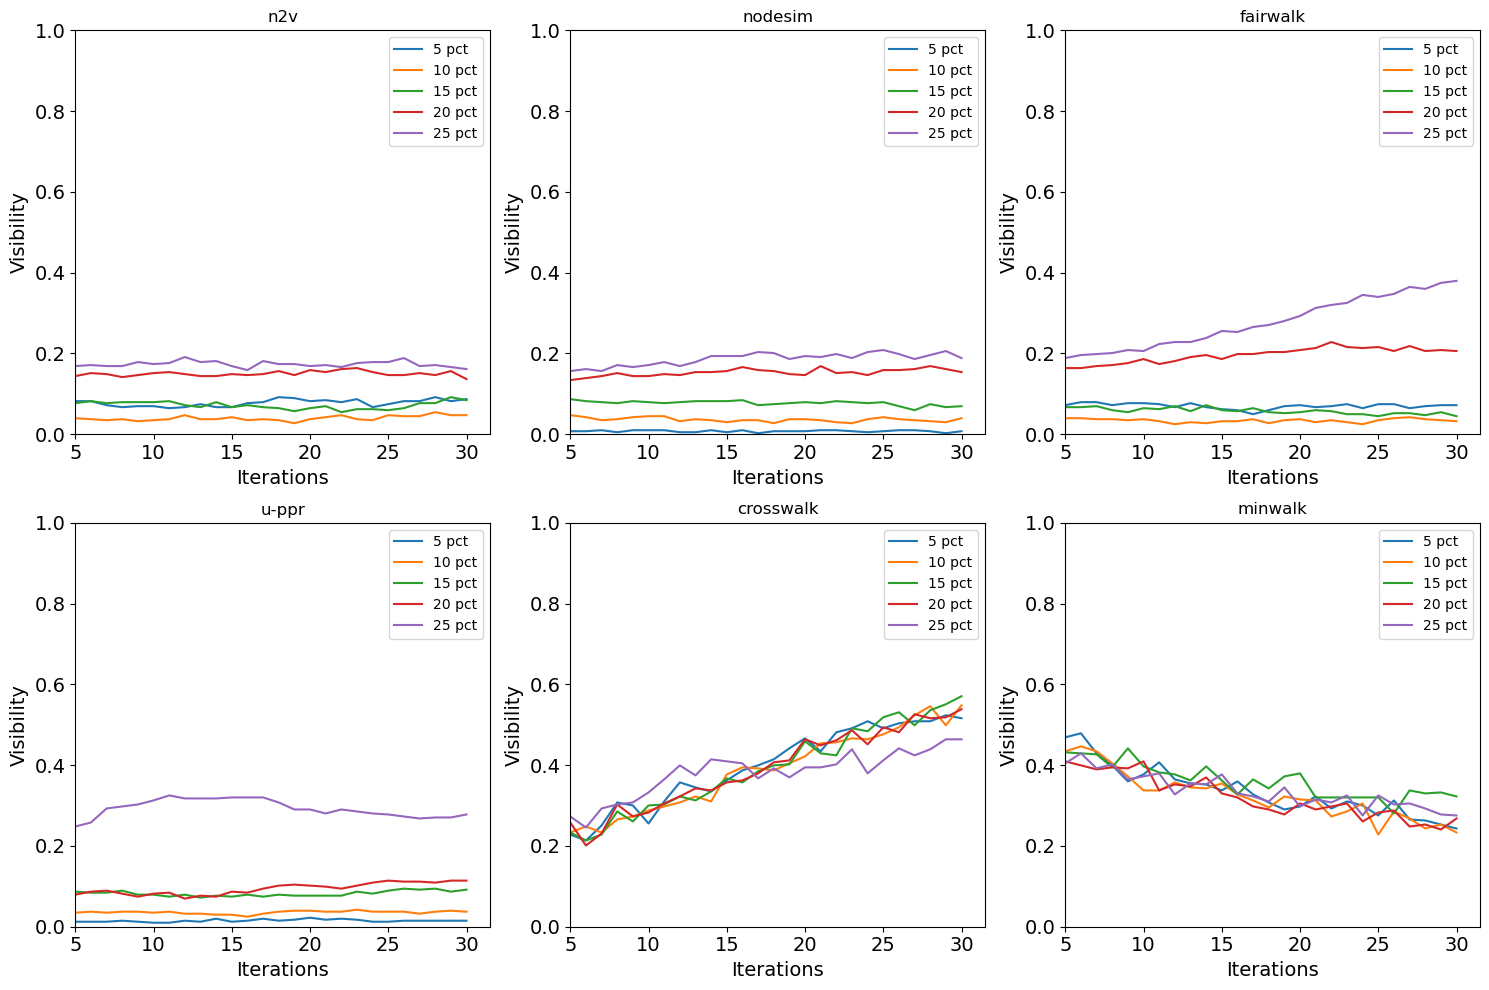

In [28]:
import matplotlib.pyplot as plt

# Assuming combined_dataframes is your final dictionary with the dataframes
algorithms = list(combined_dataframes.keys())

# Map suffix to y-axis label
y_label_map = {
    'vis': 'Visibility',
    'clu': 'Clustering Coefficient',
    'gin': 'Gini'
}

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to easily loop over it

for i, alg in enumerate(algorithms):
    ax = axes[i]
    df = combined_dataframes[alg]

    # Plot the data
    df.plot(kind='line', ax=ax)  # Example: line plot

    ax.set_title(alg)
    ax.set_xlabel('Iterations', fontsize=14)  # Set x-axis label as 'Iterations' with font size 16
    ax.set_ylabel(y_label_map.get(suff, 'Value'), fontsize=14)  # Set y-axis label with font size 16
    ax.set_ylim(0, 1)  # Set y-axis scale from 0 to 1
    ax.set_xlim(left=5)  # Set x-axis to start from iteration 5

    # Increase the font size of the tick labels
    ax.tick_params(axis='both', labelsize=14)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the figure as a PDF
plt.savefig(f'plot.vary_minority_sizes.{suff}.pdf', format='pdf')

# Show the plot
plt.show()
